# Machine Learning et Marketting - correction

In [ ]:
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

### Données

Tout d'abord, on récupère la base de données : [Bank Marketing Data Set](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/"
file = "bank.zip"
import pyensae
data = pyensae.download_data(file, website=url)

In [ ]:
import pandas
df = pandas.read_csv("bank.csv",sep=";")
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no
4520,44,entrepreneur,single,tertiary,no,1136,yes,yes,cellular,3,apr,345,2,249,7,other,no


### Exercice 1 : prédire y en fonction des attributs

Les données ne sont pas toutes au format numérique, il faut convertir les variables catégorielles. Pour cela, on utilise la fonction [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html).

In [ ]:
import numpy
import numpy as np
numerique = [ c for c,d in zip(df.columns,df.dtypes) if d == numpy.int64 ]
categories = [ c for c in df.columns if c not in numerique and c not in ["y"] ]
target = "y"
print(numerique)
print(categories)
print(target)
num = df[ numerique ]
cat = df[ categories ]
tar = df[ target ]

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
y


On traite les variables catégorielles :

In [ ]:
from sklearn.feature_extraction import DictVectorizer
prep = DictVectorizer()
cat_as_dicts = [dict(r.iteritems()) for _, r in cat.iterrows()]
temp = prep.fit_transform(cat_as_dicts)
cat_exp = temp.toarray()
prep.feature_names_

['contact=cellular',
 'contact=telephone',
 'contact=unknown',
 'default=no',
 'default=yes',
 'education=primary',
 'education=secondary',
 'education=tertiary',
 'education=unknown',
 'housing=no',
 'housing=yes',
 'job=admin.',
 'job=blue-collar',
 'job=entrepreneur',
 'job=housemaid',
 'job=management',
 'job=retired',
 'job=self-employed',
 'job=services',
 'job=student',
 'job=technician',
 'job=unemployed',
 'job=unknown',
 'loan=no',
 'loan=yes',
 'marital=divorced',
 'marital=married',
 'marital=single',
 'month=apr',
 'month=aug',
 'month=dec',
 'month=feb',
 'month=jan',
 'month=jul',
 'month=jun',
 'month=mar',
 'month=may',
 'month=nov',
 'month=oct',
 'month=sep',
 'poutcome=failure',
 'poutcome=other',
 'poutcome=success',
 'poutcome=unknown']

On construit les deux matrices $(X,Y)$ = (features, classe).

**Remarque :** certains modèles d'apprentissage n'acceptent pas les corrélations. Lorsqu'on crée des variables catégorielles à choix unique, les sommes des colonnes associées à une catégories fait nécessairement un. Avec deux variables catégorielles, on introduit nécessairement des corrélations. On pense à enlever les dernières catégories : ``'contact=unknown', 'default=yes', 'education=unknown',`` ``'housing=yes',`` ``'job=unknown', 'loan=yes', 'marital=single', 'month=sep',`` ``'poutcome=unknown'``.

In [ ]:
cat_exp_df = pandas.DataFrame( cat_exp, columns = prep.feature_names_ )
reject = ['contact=unknown', 'default=yes', 'education=unknown', 'housing=yes','job=unknown', 
          'loan=yes', 'marital=single', 'month=sep', 'poutcome=unknown']
keep = [ c for c in cat_exp_df.columns if c not in reject ]
cat_exp_df_nocor = cat_exp_df [ keep ]
X = pandas.concat ( [ num, cat_exp_df_nocor ], axis= 1)
Y = tar.apply( lambda r : (1.0 if r == "yes" else 0.0))
X.shape, Y.shape

((4521, 42), (4521,))

Quelques corrélations sont très grandes malgré tout :

In [ ]:
import numpy
numpy.corrcoef(X)

array([[ 1.        ,  0.99733687,  0.96756321, ...,  0.89646012,
         0.9809934 ,  0.94772372],
       [ 0.99733687,  1.        ,  0.98202501, ...,  0.8917544 ,
         0.99153146,  0.96013301],
       [ 0.96756321,  0.98202501,  1.        , ...,  0.90132068,
         0.998155  ,  0.98697606],
       ..., 
       [ 0.89646012,  0.8917544 ,  0.90132068, ...,  1.        ,
         0.90491984,  0.94963638],
       [ 0.9809934 ,  0.99153146,  0.998155  , ...,  0.90491984,
         1.        ,  0.98331872],
       [ 0.94772372,  0.96013301,  0.98697606, ...,  0.94963638,
         0.98331872,  1.        ]])

On divise en base d'apprentissage et de test :

In [ ]:
from sklearn.cross_validation import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33)

Puis on cale un modèle d'apprentissage :

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
type_classifier = GradientBoostingClassifier
clf = type_classifier()
clf = clf.fit(X_train, Y_train.ravel()) 

La méthode [ravel](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.ravel.html#pandas.Series.ravel) évite de prendre en compte l'index de *Y_train*. La méthode [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html) conserve dans l'index les positions initiales des élèments. Mais l'index fait que ``Y_train[0]`` ne désigne pas le premier élément de ``Y_train`` mais le premier élément du tableau initial. ``Y_train.ravel()[0]`` désigne bien le premier élément du tableau. On calcule ensuite la matrice de confusion ([Confusion matrix](http://scikit-learn.org/stable/auto_examples/plot_confusion_matrix.html)) :

[[2685   14]
 [ 161  169]]
[[1261   40]
 [ 120   71]]


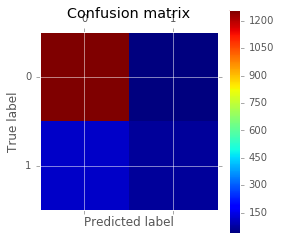

In [ ]:
from sklearn.metrics import confusion_matrix
for x,y in [ (X_train, Y_train), (X_test, Y_test) ]:
    yp  = clf.predict(x)
    cm = confusion_matrix(y.ravel(), yp.ravel())
    print(cm)
    
import matplotlib.pyplot as plt
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label') 

Si le model choisi est un [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), on peut regarder l'importance des variables dans la construction du résultat. Le graphe suivant est inspiré de la page [Gradient Boosting regression](http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html) même si ce n'est pas une régression qui a été utilisée ici.

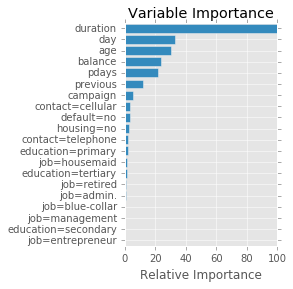

In [ ]:
import numpy as np
feature_name = X.columns

limit = 20
feature_importance = clf.feature_importances_[:20]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_name[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

Il faut tout de même rester prudent quant à l'interprétation du graphe précédent. La documentation au sujet de l[importance des features](http://scikit-learn.org/stable/modules/ensemble.html#feature-importance-evaluation) précise plus ou moins comment sont calculés ces chiffres. Toutefois, lorsque des variables sont très corrélées, elles sont plus ou moins interchangeables. Tout dépend alors comment l'algorithme d'apprentissage choisit telle ou telle variables, toujours dans le même ordre ou dans un ordre aléatoire.

#### variables

On utilise le code de la séance 3 [Analyse en Composantes Principales](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx/notebooks/td2a_cenonce_session_3A.html?highlight=acp#PCA) pour observer les variables.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
x_transpose = X.T
pca.fit(x_transpose)

PCA(copy=True, n_components=4, whiten=False)

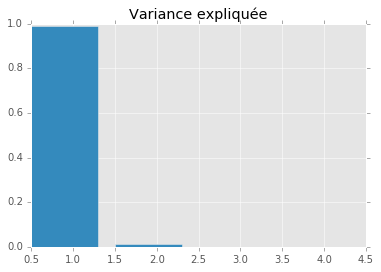

In [ ]:
plt.bar(numpy.arange(len(pca.explained_variance_ratio_))+0.5, pca.explained_variance_ratio_)
plt.title("Variance expliquée")

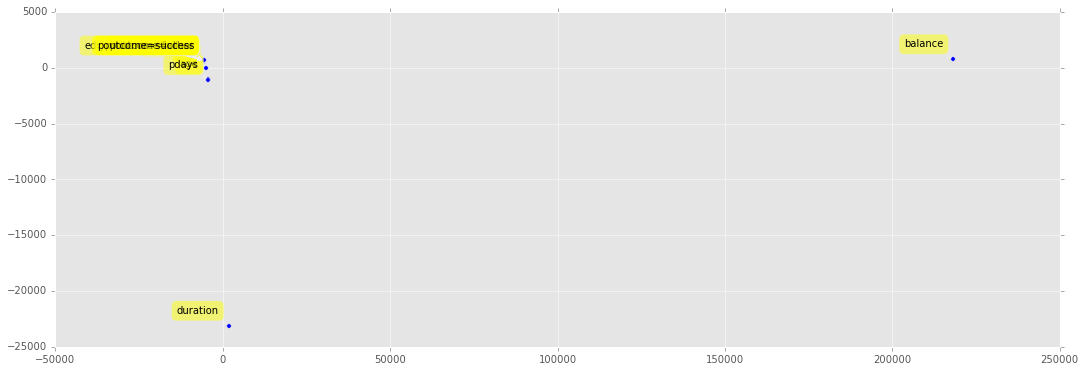

In [ ]:
import warnings
warnings.filterwarnings('ignore')
X_reduced = pca.transform(x_transpose)
plt.figure(figsize=(18,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for label, x, y in zip(x_transpose.index, X_reduced[:, 0], X_reduced[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

Les variables les plus dissemblables sont celles qui contribuent le plus. Toutefois, à la vue de ce graphique, il apparaît qu'il faut normaliser les données avant d'interpréter l'ACP :

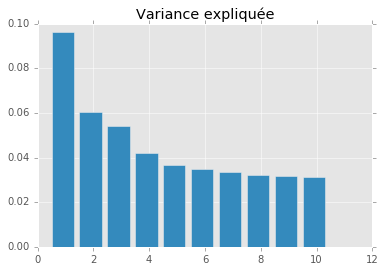

In [ ]:
from sklearn.preprocessing import normalize
xnorm = normalize(x_transpose)
pca = PCA(n_components=10)
pca.fit(xnorm)
plt.bar(numpy.arange(len(pca.explained_variance_ratio_))+0.5, pca.explained_variance_ratio_)
plt.title("Variance expliquée")

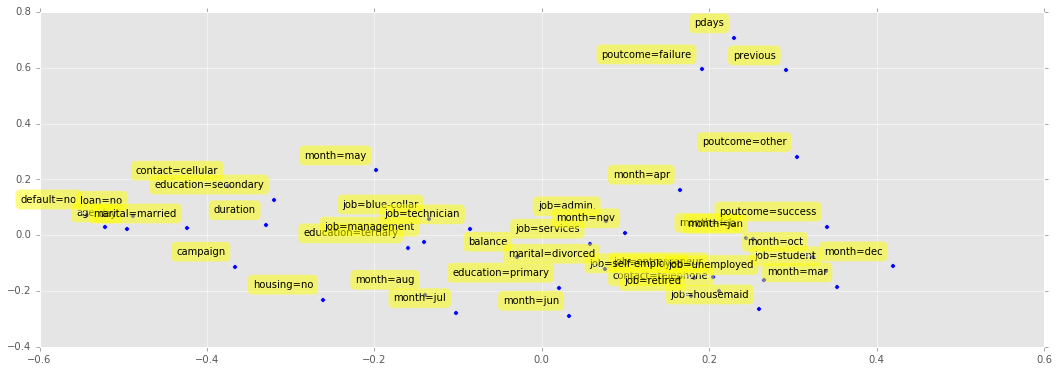

In [ ]:
X_reduced = pca.transform(xnorm)
plt.figure(figsize=(18,6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1])
for label, x, y in zip(x_transpose.index, X_reduced[:, 0], X_reduced[:, 1]):
    plt.annotate(
        label,
        xy = (x, y), xytext = (-10, 10),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

Nettement mieux. En règle générale, il est préférable de normaliser ses données avant d'apprendre un modèle. Cela n'est pas toujours nécessaire (comme pour les arbres de décision). Toutefois, numériquement, avoir des données d'ordre de grandeur très différent introduit toujours plus d'approximations.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import GradientBoostingClassifier

clf = Pipeline([
      ('normalize', Normalizer()),
      ('classification', GradientBoostingClassifier())
    ])
clf = clf.fit(X_train, Y_train.ravel()) 

In [ ]:
from sklearn.metrics import confusion_matrix
x,y = X_test, Y_test
yp  = clf.predict(x)
cm2 = confusion_matrix(y, yp)
print("non normalisé\n",cm)
print("normalisé\n",cm2)

non normalisé
 [[1261   40]
 [ 120   71]]
normalisé
 [[1270   31]
 [ 127   64]]


C'est plus ou moins équivalent lorsque les variables sont normalisées dans ce cas. Il faudrait vérifier sur la courbe ROC.

### Exercice 2 : tracer la courbe ROC

On utilise l'exemple [Receiver Operating Characteristic (ROC)](http://scikit-learn.org/stable/auto_examples/plot_roc.html) qu'il faut modifié car la réponse juste dans notre cas est le fait de prédire la bonne classe. Cela veut dire qu'il y a deux cas pour lesquels le modèle prédit le bon résultat : on choisit la classe qui la probabilité la plus forte.

In [ ]:
from sklearn.metrics import roc_curve, auc
probas = clf.predict_proba(X_test)
probas[:5]

array([[ 0.9792842 ,  0.0207158 ],
       [ 0.98228488,  0.01771512],
       [ 0.83708208,  0.16291792],
       [ 0.98675536,  0.01324464],
       [ 0.98818146,  0.01181854]])

On construit le vecteur des bonnes réponses :

In [ ]:
rep = [ ]
yt = Y_test.ravel()
for i in range(probas.shape[0]):
    p0,p1 = probas[i,:]
    exp = yt[i]
    if p0 > p1 :
        if exp == 0 :
            # bonne réponse
            rep.append ( (1, p0) )
        else :
            # mauvaise réponse
            rep.append( (0,p0) )
    else :
        if exp == 0 :
            # mauvaise réponse
            rep.append ( (0, p1) )
        else :
            # bonne réponse
            rep.append( (1,p1) )
mat_rep = numpy.array(rep)
mat_rep[:5]

array([[ 1.        ,  0.9792842 ],
       [ 1.        ,  0.98228488],
       [ 1.        ,  0.83708208],
       [ 1.        ,  0.98675536],
       [ 1.        ,  0.98818146]])

In [ ]:
"taux de bonne réponse",sum(mat_rep[:,0]/len(mat_rep)) # voir matrice de confusion

('taux de bonne réponse', 0.89410187667560337)

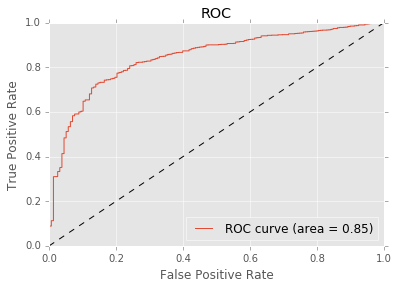

In [ ]:
fpr, tpr, thresholds = roc_curve(mat_rep[:,0], mat_rep[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")

Ce score n'est pas si mal pour un premier essai. On n'a pas tenu compte du fait que la classe 1 est sous-représentée (voir [Quelques astuces pour faire du machine learning](http://www.xavierdupre.fr/blog/2014-03-28_nojs.html). A priori, ce ne devrait pas être le cas du [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). C'est une famille de modèles qui, lors de l'apprentissage, pondère davantage les exemples où ils font des erreurs. L'algorithme de  [boosting](http://fr.wikipedia.org/wiki/Boosting) le plus connu est [AdaBoost](http://fr.wikipedia.org/wiki/AdaBoost).

On tire maintenant deux échantillons aléatoires qu'on ajoute au graphique précédent :

(697,) (697,) (699,) (699,)


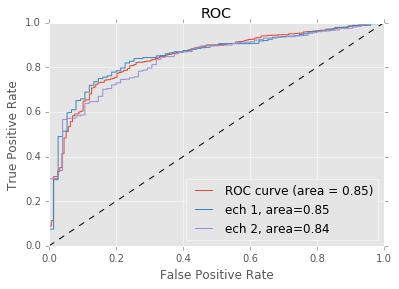

In [ ]:
import random
Y1 = numpy.array([ random.randint(0,1) == 0 for i in range(0,mat_rep.shape[0]) ])
Y2 = numpy.array([ random.randint(0,1) == 0 for i in range(0,mat_rep.shape[0]) ])

fpr1, tpr1, thresholds1 = roc_curve(mat_rep[Y1,0], mat_rep[Y1, 1])
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, thresholds2 = roc_curve(mat_rep[Y2,0], mat_rep[Y2, 1])
roc_auc2 = auc(fpr2, tpr2)
print(fpr1.shape,tpr1.shape,fpr2.shape,tpr2.shape)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1,2], [0, 1,2], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')
ax.plot(fpr1, tpr1, label='ech 1, area=%0.2f' % roc_auc1)
ax.plot(fpr2, tpr2, label='ech 2, area=%0.2f' % roc_auc2)
ax.legend(loc="lower right")

### Exercice 3 : d3js

La première version est réalisé avec [mpld3](http://mpld3.github.io/).

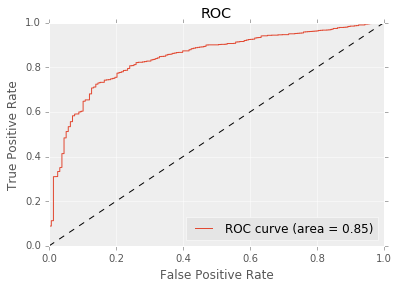

In [ ]:
from mpld3 import plugins, save_html

fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
ax.grid(color='white', linestyle='solid')

fpr, tpr, thresholds = roc_curve(mat_rep[:,0], mat_rep[:, 1])
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC')
ax.legend(loc="lower right")

labels = ['{0},{1}={2}'.format(f,t,th) for f,t,th in zip(fpr,tpr,thresholds)]
fig.plugins = [plugins.PointLabelTooltip(ax, labels)]
save_html(fig, "graph.html")

La seconde version est avec [d3.js](http://d3js.org/).

In [ ]:
import numpy, pandas
mat = numpy.zeros( (len(fpr),3))
mat[:,0] = fpr
mat[:,1] = tpr
mat[:,2] = thresholds
df = pandas.DataFrame( mat, columns= ["fpr","tpr","th"])
df.to_csv("data_roc.csv",sep=",")

In [ ]:
style = """
.axis path,
.axis line {
  fill: none;
  stroke: #000;
  shape-rendering: crispEdges;
}

.dot {
  stroke: #000;
}

.tooltip {
  position: relative;
  width: 200px;
  height: 28px;
  //pointer-events: none;
}
"""

id_graph = "mongraph"

code_graph = """
var margin = {top: 20, right: 20, bottom: 30, left: 40},
    width = 960 - margin.left - margin.right,
    height = 500 - margin.top - margin.bottom;

var xValue = function(d) { return d["fpr"];}, // data -> value
    xScale = d3.scale.linear().range([0, width]), // value -> display
    xMap = function(d) { return xScale(xValue(d));}, // data -> display
    xAxis = d3.svg.axis().scale(xScale).orient("bottom");
    
var thValue = function(d) { return d["th"];} 

// setup y
var yValue = function(d) { return d["tpr"];}, // data -> value
    yScale = d3.scale.linear().range([height, 0]), // value -> display
    yMap = function(d) { return yScale(yValue(d));}, // data -> display
    yAxis = d3.svg.axis().scale(yScale).orient("left");

// setup fill color
var cValue = function(d) { return "ROC";},
    color = d3.scale.category10();

var svg = d3.select("#__IDGRAPH__").append("svg")
    .attr("width", width + margin.left + margin.right)
    .attr("height", height + margin.top + margin.bottom)
  .append("g")
    .attr("transform", "translate(" + margin.left + "," + margin.top + ")");

var tooltip = d3.select("#__IDGRAPH__").append("div")
    .attr("class", "tooltip")
    .style("opacity", 0);

d3.csv("__FILE__", function(error, data) {

  data.forEach(function(d) {
    d.tpr = +d.tpr;
    d.fpr = +d.fpr;
    //console.log(d);
  });

  xScale.domain([d3.min(data, xValue)-1, d3.max(data, xValue)+1]);
  yScale.domain([d3.min(data, yValue)-1, d3.max(data, yValue)+1]);

  svg.append("g")
      .attr("class", "x axis")
      .attr("transform", "translate(0," + height + ")")
      .call(xAxis)
    .append("text")
      .attr("class", "label")
      .attr("x", width)
      .attr("y", -6)
      .style("text-anchor", "end")
      .text("TPR");

  svg.append("g")
      .attr("class", "y axis")
      .call(yAxis)
    .append("text")
      .attr("class", "label")
      .attr("transform", "rotate(-90)")
      .attr("y", 6)
      .attr("dy", ".71em")
      .style("text-anchor", "end")
      .text("FPR");

  // draw dots
  svg.selectAll(".dot")
      .data(data)
    .enter().append("circle")
      .attr("class", "dot")
      .attr("r", 3)                     // taille des ronds
      .attr("cx", xMap)
      .attr("cy", yMap)
      .style("fill", function(d) { return color(cValue(d));}) 
      .on("mouseover", function(d) {
          tooltip.transition()
               .duration(200)
               .style("opacity", .9);
          tooltip.html(d["threshold"] + "<br/> (" + xValue(d) 
         + ", " + yValue(d) + "-" + thValue(d) + ")")
               .style("left", (d3.event.pageX + 5) + "px")
               .style("top", (d3.event.pageY - 28) + "px");
      })
      .on("mouseout", function(d) {
          tooltip.transition()
               .duration(500)
               .style("opacity", 0);
      })
      ;

  // draw legend
  var legend = svg.selectAll(".legend")
      .data(color.domain())
    .enter().append("g")
      .attr("class", "legend")
      .attr("transform", function(d, i) { return "translate(0," + i * 20 + ")"; });

  // draw legend colored rectangles
  legend.append("rect")
      .attr("x", width - 18)
      .attr("width", 18)
      .attr("height", 18)
      .style("fill", color);

  // draw legend text
  legend.append("text")
      .attr("x", width - 24)
      .attr("y", 9)
      .attr("dy", ".35em")
      .style("text-anchor", "end")
      .text(function(d) { return d;})
});
"""

In [ ]:
html_src = """
<style>
{0}
</style>
<div id="{1}"></div>
""".format(style, id_graph)

js_src = code_graph.replace("__IDGRAPH__", id_graph) \
                   .replace("__FILE__", "/notebooks/td2a/data_roc.csv")
                    # ~ http://localhost:8888/notebooks/td2a/cereales.csv
 
js_libs = ['http://d3js.org/d3.v3.js']
 
import IPython
from IPython.core.display import display, Javascript, HTML
display( Javascript(data=js_src, lib= js_libs))
display(HTML(html_src))

<IPython.core.display.Javascript object>

Et si la conversion en HTML ne fonctionne pas :

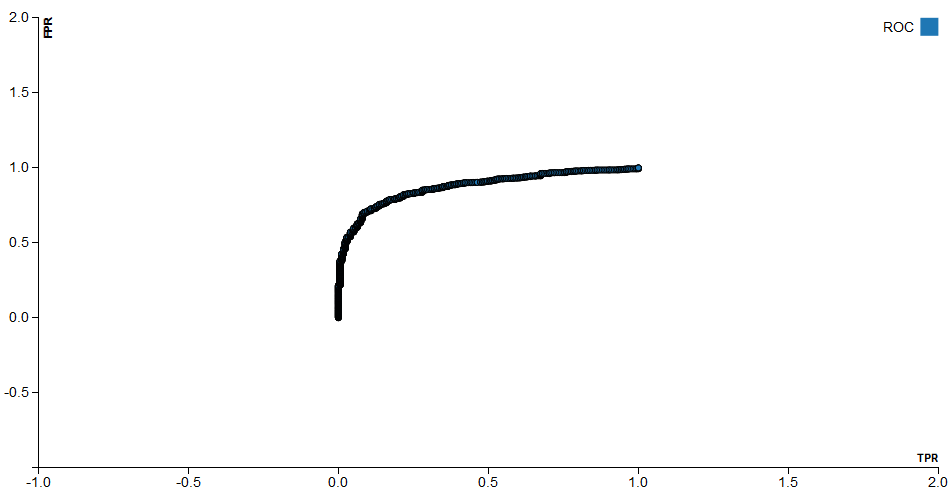

In [ ]:
from IPython.core.display import Image
Image("d3jsex2.png")